In [1]:
import numpy as np
from tqdm import tqdm
import anndata as ad
import sys
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.io import savemat, loadmat
import os
import pandas as pd

In [2]:
data_folder = 'data/thomsonlab_signaling/'
large_data_folder = 'large_data/thomsonlab_signaling/'
fig_folder = 'figure/thomsonlab_signaling/'

In [3]:
cadata = ad.read_h5ad(large_data_folder + 'thomsonlab_signaling_filtered_2500_scvi_umap.h5ad')

/Users/ygong/anaconda3/envs/be206/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
seed = 0
num_spin = 20
num_pool = num_spin
num_repeat = 10
task_name = 'thomsonlab_signaling'
save_path = "./test/test_signalling/"

## Test with DSPIN Class

In [5]:
from util.dspin import DSPIN

In [18]:
# Reload the Package
from importlib import reload
import util.dspin  
reload(util.dspin)  
from util.dspin import DSPIN 

In [19]:
a = DSPIN(cadata, save_path, num_spin)

In [20]:
a.preprocessing()

100%|██████████| 24/24 [00:00<00:00, 48.99it/s]


(array([[0.        , 0.        , 0.        , ..., 3.89765967, 0.8545528 ,
         5.91626121],
        [1.76288435, 0.        , 0.        , ..., 3.59678512, 0.68008155,
         5.04734838],
        [0.        , 0.        , 0.        , ..., 3.4345976 , 0.        ,
         5.75988877],
        ...,
        [0.        , 0.        , 0.        , ..., 1.59652077, 0.        ,
         4.20906474],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         3.22669189]]),
 array([1.        , 0.91539076, 1.        , ..., 1.        , 1.        ,
        1.        ]))

Pre-computing
Round_1


100%|██████████| 500/500 [01:58<00:00,  4.21it/s]


Round_2


100%|██████████| 500/500 [01:59<00:00,  4.20it/s]


Round_3


100%|██████████| 500/500 [01:55<00:00,  4.33it/s]


Round_4


100%|██████████| 500/500 [02:09<00:00,  3.87it/s]


Round_5


100%|██████████| 500/500 [02:08<00:00,  3.89it/s]


Round_6


100%|██████████| 500/500 [02:04<00:00,  4.00it/s]


Round_7


100%|██████████| 500/500 [02:03<00:00,  4.05it/s]


Round_8


100%|██████████| 500/500 [02:12<00:00,  3.78it/s]


Round_9


100%|██████████| 500/500 [02:03<00:00,  4.03it/s]


Round_10


100%|██████████| 500/500 [02:10<00:00,  3.84it/s]
/Users/ygong/anaconda3/envs/be206/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ygong/anaconda3/envs/be206/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/ygong/anaconda3/envs/be206/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/bt/8lz5hj4d0fbbslj5lj4c85qm0000gn/T/ipykernel_46694/3216018670.py", line 1, in <module>
    a.onmf_abstract()
  File "/Users/ygong/git/DSPIN-abstract/util/dspin.py", line 233, in onmf_abstract
    self.onmf_summary (onmf_summary)
TypeError: 'NoneType' object is not callable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/ygong/anaconda3/envs/be206/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ygong/anaconda3/envs/be206/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1310, in structured_traceback
    return Fo

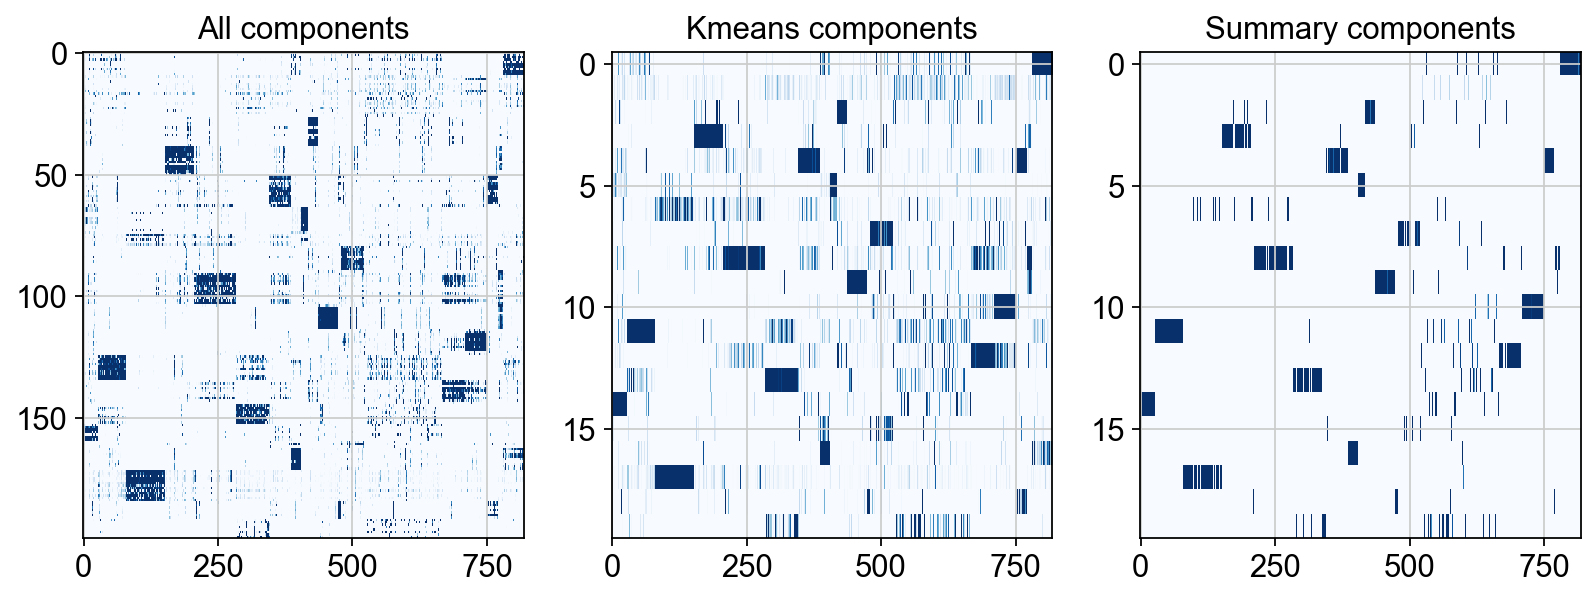

In [21]:
a.onmf_abstract()

In [22]:
onmf_rep_ori = a.compute_onmf_rep_ori()

AttributeError: 'NoneType' object has no attribute 'transform'

In [ ]:
onmf_rep_tri = a.discretize()

### Verification the Correctness of ONMF Representation

In [ ]:
from util.plotting import onmf_gene_program_info

num_gene_show = 20
features = a.onmf_summary.components_
gene_name = cadata.var_names

onmf_gene_program_info(features, gene_name, num_gene_show, fig_folder)

#### Visualization of gene program decomposition

In [ ]:
onmf_rep_tri = a.onmf_rep_tri
features = onmf_summary.components_
num_gene_select = 10
gene_mod_ind = np.argmax(features, axis=0)

gene_mod_use = []
for ind in range(num_spin):
    ii = ind
    gene_in_mod = np.where(gene_mod_ind == ii)[0]
    cur_gene = gene_in_mod[np.argsort(- features[ii, gene_in_mod])[: num_gene_select]]
    gene_mod_use += list(cur_gene)
gene_mod_use = np.array(gene_mod_use)

np.random.seed(0)
subset_ind = np.random.choice(range(gene_matrix.shape[0]), size=10000, replace=False)
cell_order = np.argsort(KMeans(n_clusters=4).fit_predict(onmf_rep_tri[subset_ind, :]))
gene_matrix_subset = gene_matrix[subset_ind, :][:, gene_mod_use]
gene_matrix_subset /= np.max(gene_matrix, axis=0)[gene_mod_use].clip(0.2, np.inf)

sc.set_figure_params(figsize=[10, 5])

plt.subplot(1, 2, 1)
plt.imshow(gene_matrix_subset[cell_order, :].T, aspect='auto', cmap='Blues', interpolation='none')
plt.ylabel('Gene')
plt.xlabel('Cell')
plt.title('Gene expression')
plt.grid()

plt.subplot(1, 2, 2)
plt.imshow(onmf_rep_tri[subset_ind, :][cell_order, :].T, aspect='auto', cmap='Blues', interpolation='none')
plt.yticks(range(num_spin), spin_name_extend, fontsize=12)
plt.gca().yaxis.set_ticks_position('right')
plt.xlabel('Cell');
plt.title('Gene program expression')
plt.grid()

plt.savefig(fig_folder + 'gene_program_example.png', bbox_inches='tight')

In [ ]:
a.cross_corr('sample_batch')

In [ ]:
a.post_processing()